# Brain Tumor Detection

![](images/notebook.png)

---
Magnetic Resonance Imaging (MRI) scans are considered the best tool for analyzing tumors in the brain. "Brain tumors account for 85 to 90 percent of all primary Central Nervous System(CNS) tumors. Every year, around 11,700 people are diagnosed with a brain tumor... A huge amount of image data is generated through the scans. These images are examined by the radiologist. A manual examination can be error-prone due to the level of complexities involved in brain tumors and their properties" [Kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri). 

The purpose of this project will be to deploy a deep learning model that can accurately classify MRI brain tumor images into four different categories:
- Glioma - a tumor made of astrocytes that occurs in the brain and spinal cord
- Meningioma - a usually noncancerous tumor that arises from the membranes surrounding the brain and spinal cord.
- None - no tumor present in brain. 
- Pituitary - a tumor that forms in the pituitary gland near the brain that can change hormone levels.

*Data originally came from [Kaggle](https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri) but was cloned from the original [GitHub Repo](https://github.com/sartajbhuvaji/brain-tumor-classification-dataset) containing the images for easy of use.*


In [2]:
!pip3 install --upgrade tensorflow # needed for tf.data.AUTOTUNE (SageMaker uses 2.1.3, we need 2.4.1)

In [1]:
!pip3 install tqdm

     |████████████████████████████████| 75 kB 3.8 MB/s eta 0:00:011


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import os 
import cv2
import time
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

sns.set_style("darkgrid", {'axes.edgecolor': 'black'})
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams["legend.fontsize"] = 13

tf.__version__

'2.4.1'

## Loading Images

Although the data is seperated into training and testing directories, and th subdirectories contain the labels for the images, we won't be using the data_from_directory function. Data will be loaded from the subdirectories, put into numpy arrays, and combined together for all classes in both training and testing data (in seperate arrays). We will use [OpenCV](https://docs.opencv.org/master/) to read in and resize the images, then returning a tuple with the loaded image and its corresponding labels.

In [3]:
def load_images(main_dir, sub_dir):
    '''
    Using OpenCV, load the images for a directory and return the image/label as a tuple. 
    Image will be resized to 224x224. Filenames will also be returned to be used 
    for plotting loaded images against filenames to make sure they were correctly loaded and labeled.
    '''
    filenames = glob.glob(f'{main_dir}/{sub_dir}/*.jpg')
    assert len(filenames) == len(os.listdir(f'{main_dir}/{sub_dir}')) # make sure all images loaded
    x = np.array([cv2.resize(cv2.imread(fname), (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA) for fname in filenames])
    y = np.array([sub_dir] * len(filenames)) # create labels for images (sub directory name)
    assert len(x) == len(y) # make sure each image has a label
    return x, y, filenames    

#### Training Images

In [4]:
img_type = 'Training'
sub_dir_names = next(os.walk(img_type))[1] # get training subdirectories
start = time.time() # start time

# create initial arrays for first subdirectory
x_train, y_train, filenames_train = load_images(img_type,'no_tumor')
print('Successfully loaded no_tumor directory.')

# concatenate remaining subdirectories to the above arrays
for sub_dir in sub_dir_names[1:4]:
    x_tmp, y_tmp, filenames_tmp = load_images(img_type, sub_dir)
    x_train = np.concatenate([x_train, x_tmp], axis=0)
    y_train = np.concatenate([y_train, y_tmp], axis=0)
    filenames_train = np.concatenate([filenames_train, filenames_tmp], axis=0)
    print(f'Successfully loaded {sub_dir} directory.')
    
print(f'\nLoaded {len(x_train)} {img_type} images in {round(time.time() - start, 3)} seconds.') # 2870 total training images

Successfully loaded no_tumor directory.
Successfully loaded pituitary_tumor directory.
Successfully loaded glioma_tumor directory.
Successfully loaded meningioma_tumor directory.

Loaded 2870 Training images in 31.917 seconds.


Class Label: glioma_tumor


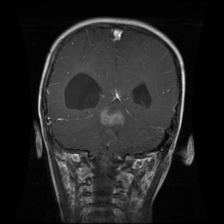

In [5]:
idx = 1741

print(f'Class Label: {y_train[idx]}') # Get image label
array_to_img(x_train[idx, :, :, :]) # Visualize loaded image

True Label: glioma_tumor


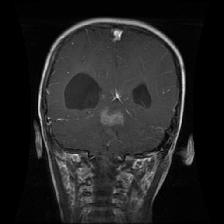

In [6]:
file_label = filenames_train[idx].split('/')[1]
print(f'True Label: {file_label}') # Get directory name (true label)
load_img(filenames_train[idx], target_size=(IMG_SIZE, IMG_SIZE)) # Get directory image (match above?) 

#### Testing Data

In [7]:
img_type = 'Testing'
sub_dir_names = next(os.walk(img_type))[1] # get training subdirectories
start = time.time() # start time

# create initial arrays for first subdirectory
x_test, y_test, filenames_test = load_images(img_type,'no_tumor')
print('Successfully loaded no_tumor directory.')

# concatenate remaining subdirectories to the above arrays
for sub_dir in sub_dir_names[1:4]:
    x_tmp, y_tmp, filenames_tmp = load_images(img_type, sub_dir)
    x_test = np.concatenate([x_test, x_tmp], axis=0)
    y_test = np.concatenate([y_test, y_tmp], axis=0)
    filenames_test = np.concatenate([filenames_test, filenames_tmp], axis=0)
    print(f'Successfully loaded {sub_dir} directory.')
    
print(f'\nLoaded {len(x_test)} {img_type} images in {round(time.time() - start, 3)} seconds.') # 394 total testing images

Successfully loaded no_tumor directory.
Successfully loaded pituitary_tumor directory.
Successfully loaded glioma_tumor directory.
Successfully loaded meningioma_tumor directory.

Loaded 394 Testing images in 3.916 seconds.


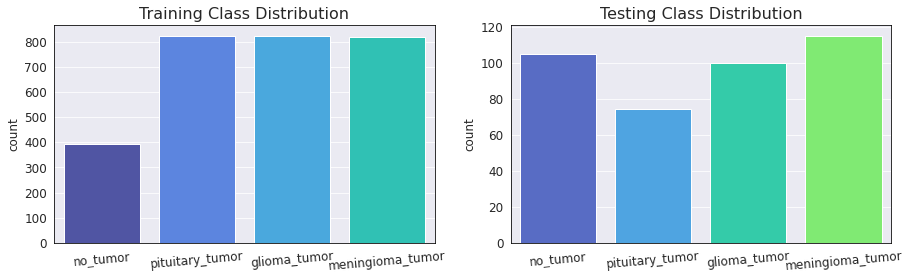

In [8]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
sns.countplot(x=y_train, palette=sns.color_palette('turbo', 12))
plt.title('Training Class Distribution')
plt.xticks(rotation=5)
ax2 = plt.subplot(1,2,2)
sns.countplot(x=y_test, palette=sns.color_palette('turbo', 8))
plt.title('Testing Class Distribution')
plt.xticks(rotation=5)
plt.show();

For the training data, we seem to have around half as many observations for *no_tumor* compared to the other classes, but this should not be too large of an issue. The remainig classes seem to be balanced with around 800 observations each. For testing data, our classes seem to be mostly balanced (no extreme difference between max and min observations). 

## Image Preprocessing

In [9]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=42)
filenames_test = None
filenames_train = None

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [11]:
def cast_and_normalize(image, label):
    image = tf.convert_to_tensor(image) # convert to tensor
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize
    return image, label

def train_augment(image, label):
    seed = np.random.randint(1, 150, size=1)[0]
    image = tf.convert_to_tensor(image) # convert to tensor
    image = tf.image.random_flip_up_down(image, seed=seed) # random flip
    image = tf.image.random_flip_left_right(image, seed=seed) # random flip
    image = tf.image.random_brightness(image, max_delta=0.2, seed=seed) # random brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.2, seed=seed) # random contrast   
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize
    return image, label

In [12]:
train_dataset = (
    train_dataset
    .shuffle(1000)
    .map(train_augment, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print('Train Dataset Augmented')

val_dataset = (
    val_dataset
    .shuffle(1000)
    .map(cast_and_normalize, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print('Validation Dataset Normalized')

test_dataset = (
    test_dataset
    .shuffle(1000)
    .map(cast_and_normalize, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)
print('Testing Dataset Normalized')

Train Dataset Augmented
Validation Dataset Normalized
Testing Dataset Normalized


In [13]:
def show_images(images, labels):
    plt.figure(figsize=(15, 10))
    labels = labels.astype('str')
    for i in range(20):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis("off")

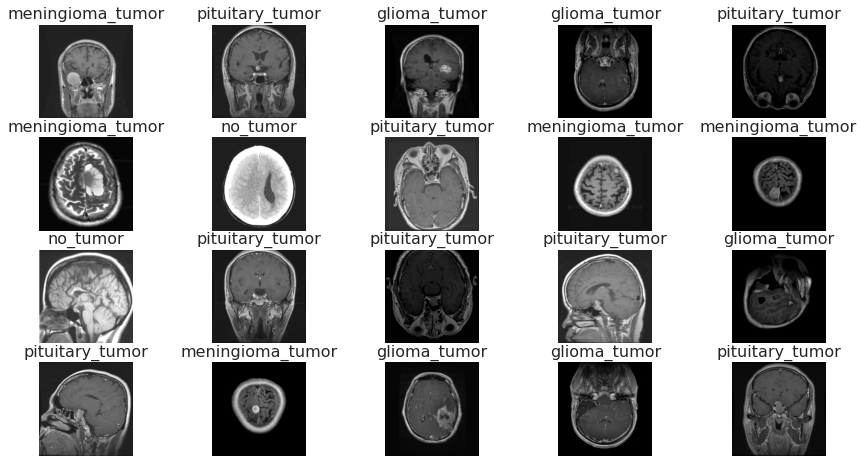

In [13]:
train_images, train_labels = next(train_dataset.as_numpy_iterator())
show_images(train_images, train_labels)

### TFRecord Conversion

- Functions for encoding and decoding of images comes from [StackOverflow](https://stackoverflow.com/questions/49511753/python-byte-image-to-numpy-array-using-opencv)
- TFRecord conversion functions (byte, float, int) come from the [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/load_data/tfrecord#walkthrough_reading_and_writing_image_data) on reading/writing image data.

In [46]:
labels = {
    'glioma_tumor': 0,
    'meningioma_tumor': 1,
    'no_tumor': 2,
    'pituitary_tumor': 3
}

image_feature_description = {
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

def encodeImage(data):
    data= cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    return bytes(data)

def decodeImage(data):
    decoded = np.frombuffer(data, dtype=np.float32) # changed from np.fromstring()
    decoded = decoded.reshape((IMG_SIZE, IMG_SIZE,3)) # convert to image dimensions
    return decoded

In [47]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def tf_image_format(image, label):
    feature = {
        'label': _int64_feature(labels[label]), # labels is dict containing one-hot-encoding mapping
        'image_raw': _bytes_feature(image)
    }
    
    return tf.train.Example(features = tf.train.Features(feature=feature))

def _parse_image_function(image):
    # Read the tfrecord file, return image and label
    return tf.io.parse_single_example(image, image_feature_description)

In [116]:
train_record_file = 'train_images.tfrecords'

with tf.io.TFRecordWriter(train_record_file) as writer:
    for image, label in train_dataset.as_numpy_iterator():
        tf_example = tf_image_format(encodeImage(image), label.decode('UTF-8'))
        writer.write(tf_example.SerializeToString())

In [117]:
val_record_file = 'val_images.tfrecords'

with tf.io.TFRecordWriter(val_record_file) as writer:
    for image, label in val_dataset.as_numpy_iterator():
        tf_example = tf_image_format(encodeImage(image), label.decode('UTF-8'))
        writer.write(tf_example.SerializeToString())

In [104]:
tmp_label = None
tmp_img_decoded = None

tf_record_dataset = tf.data.TFRecordDataset(train_record_file)
train_record_dataset = tf_record_dataset.map(_parse_image_function)

for img_features in train_record_dataset:
    tmp_label = img_features['label'].numpy()
    tmp_img_decoded = decodeImage(img_features['image_raw'].numpy())
    break

0 : glioma_tumor


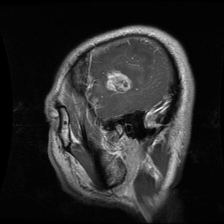

In [114]:
inv_labels = {v: k for k, v in labels.items()} # map one-hot-encoded label to string label

print(tmp_label, ':', inv_labels[tmp_label])
array_to_img(tmp_img_decoded)

We now have tfrecords files containing all of our training (1.38 GB) and validation (346 MB) images. Note that we do not need to do this to our test set since the model will be deployed/tested within this notebook (no need to upload to S3). Now that we have our record files, we can upload our training and validation sets to S3 in order to be used in our model. 

**IMPORTANT**: We will have to add the parse and decode function to our python file containing our model.